# Classifaing both Alzheimer's and Brain Tumor 

I will build step by step model to evaluate the MRI Images and find Alzheimer's disease severity, type of Brain tumor on no disease

In [13]:
import matplotlib.pyplot as plt
from os import listdir
import pandas as pd
import numpy as np

from tensorflow.keras.layers import Dense, Dropout,Flatten, GlobalAveragePooling2D 
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetV2S, resnet50
from tensorflow import expand_dims
from tensorflow.image import grayscale_to_rgb
from tensorflow.keras.preprocessing.image import load_img, img_to_array, smart_resize

import albumentations as A

from sklearn.model_selection import train_test_split

import functions

# For reproducibility
np.random.seed(18)

### Functions

In [38]:
def load_img_from_dir_cat(path, augmentation = False):
    '''
    '''
    X = []
    y = []

    for num_label, label in enumerate(listdir(path)):
        # Skip No disease folders
        if label in ('NonDemented', 'no_tumor'):
            continue
        else:
            # Change each image and append to X and y
            for image_file in listdir(f'{path}/{label}'):
                 if '.jpg' in image_file:
                    img = load_img(f'{path}/{label}/{image_file}', target_size=(image_size, image_size), color_mode='grayscale')
                    img = expand_dims(img, -1)
                    # Make image RGB for pre-trained models
                    img = grayscale_to_rgb(img)
                    img_arr = img_to_array(img) 
                    X.append(img_arr)                
                    if num_label == 3:
                        num_label = 2
                    y.append(num_label) 
                    # For training the model
    if 'train' in path:
        X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=18, stratify=y) 
        
        # Change for TensorFlow models
        X_val = np.array(X_val, dtype='float32')        
        y_val = to_categorical(y_val, num_classes=3, dtype='float32')
        
        # Apply augmentation on trainig set 
        if augmentation:
            X_train, y_train = functions.ald_augmentation(X_train, y_train)
        
        else:
            X_train = np.array(X_train, dtype='float32')
            y_train = to_categorical(y_train, num_classes=3, dtype='float32')

        return X_train, X_val, y_train, y_val
    # For testing
    else:
        X_test = np.array(X, dtype='float32')
        y_test = to_categorical(y, num_classes=3, dtype='float32')
        return X_test, y_test

In [31]:
def load_img_from_dir_binary(path):
    '''
    '''
    X = []
    y = []

    for label in listdir(path):
        # Change each image and append to X and y
        for image_file in listdir(f'{path}/{label}'):
             if '.jpg' in image_file:
                # target_size automatically resizes each img on import
                img = load_img(f'{path}/{label}/{image_file}', target_size=(image_size, image_size), color_mode='grayscale')
                img = expand_dims(img, -1)
                # Make image RGB for pre-trained models
                img = grayscale_to_rgb(img)
                img_arr = img_to_array(img) 
                X.append(img_arr)
                if label in ('NonDemented', 'no_tumor'):
                    y.append(0)
                else:
                    y.append(1)
    return X, y

In [32]:
def al_bt_load_img_from_dir_binary(path):
    '''
    '''
    X = []
    y = []

    for label in listdir(path):
        # Skip No disease folders
        if label not in ('NonDemented', 'no_tumor'):
            # Change each image and append to X and y
            for image_file in listdir(f'{path}/{label}'):
                 if '.jpg' in image_file:
                    img = load_img(f'{path}/{label}/{image_file}', target_size=(image_size, image_size), color_mode='grayscale')
                    img = expand_dims(img, -1)
                    # Make image RGB for pre-trained models
                    img = grayscale_to_rgb(img)
                    img_arr = img_to_array(img) 
                    X.append(img_arr)
                    if 'alzheimer' in path:
                        y.append(0)
                    else:
                        y.append(1)
    return X, y

In [33]:
def combine_images_from_two_path_binary(path1, path2, function = load_img_from_dir_binary):
    X_1, y_1 = function(path1)
    X_2, y_2 = function(path2)
    
    X = X_1 + X_2
    y = y_1 + y_2
    if 'train' in path1:
        X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=18, stratify=y) 
        X_train = np.array(X_train, dtype='float32')
        X_val = np.array(X_val, dtype='float32')
        y_train = np.array(y_train, dtype='float32')
        y_val = np.array(y_val, dtype='float32')
        return X_train, X_val, y_train, y_val
    else:
        X_test = np.array(X, dtype='float32')
        y_test = np.array(y, dtype='float32')
        return X_test, y_test

In [34]:
# Set image size
image_size = 240

# Set Early stopping
es = EarlyStopping(patience = 5, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

In [35]:
# Path to Alzheimer's data
al_path_train = '../data/alzheimer/train'
al_path_test = '../data/alzheimer/test'

# Path to Brain Tumor data
bt_path_train = '../data/brain_tumor/train'
bt_path_test = '../data/brain_tumor/test'

In [ ]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussNoise(p=0.5),
    A.Rotate(limit=10, p=0.25),    
    #A.RandomScale(scale_limit=0.1, p=0.5)
])

## Make Binary data Disease - No disease
Combine datasets and make binary data - disease - 1, no disease - 0

In [45]:
X_train, X_val, y_train, y_val = combine_images_from_two_path_binary(al_path_train, bt_path_train)
X_train.shape, y_train.shape

((5993, 240, 240, 3), (5993,))

In [46]:
X_test, y_test = combine_images_from_two_path_binary(al_path_test, bt_path_test)

In [47]:
rn_model_bi = resnet50.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(image_size, image_size, 3),
    classifier_activation="sigmoid"
)

for layer in rn_model_bi.layers:
    layer.trainable = False

In [48]:
model = Sequential()

model.add(rn_model_bi)
model.add(Flatten())

#Just use a single output layer
model.add(Dense(1, activation='sigmoid'))

# Compile
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

h = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=30, callbacks = [es, reduce_lr])

Epoch 1/30
188/188 [==============================] - 460s 2s/step - loss: 1.7511 - accuracy: 0.7891 - val_loss: 1.0964 - val_accuracy: 0.8053 - lr: 0.0010
Epoch 2/30
188/188 [==============================] - 470s 3s/step - loss: 0.5771 - accuracy: 0.8767 - val_loss: 0.5813 - val_accuracy: 0.8944 - lr: 0.0010
Epoch 3/30
188/188 [==============================] - 445s 2s/step - loss: 0.2349 - accuracy: 0.9408 - val_loss: 0.5765 - val_accuracy: 0.8884 - lr: 0.0010
Epoch 4/30
188/188 [==============================] - 435s 2s/step - loss: 0.1181 - accuracy: 0.9658 - val_loss: 0.6756 - val_accuracy: 0.8889 - lr: 0.0010
Epoch 5/30
188/188 [==============================] - 433s 2s/step - loss: 0.1421 - accuracy: 0.9635 - val_loss: 0.5196 - val_accuracy: 0.9189 - lr: 0.0010
Epoch 6/30
188/188 [==============================] - 426s 2s/step - loss: 0.1260 - accuracy: 0.9701 - val_loss: 1.0078 - val_accuracy: 0.8869 - lr: 0.0010
Epoch 7/30
188/188 [==============================] - 427s 2s/st

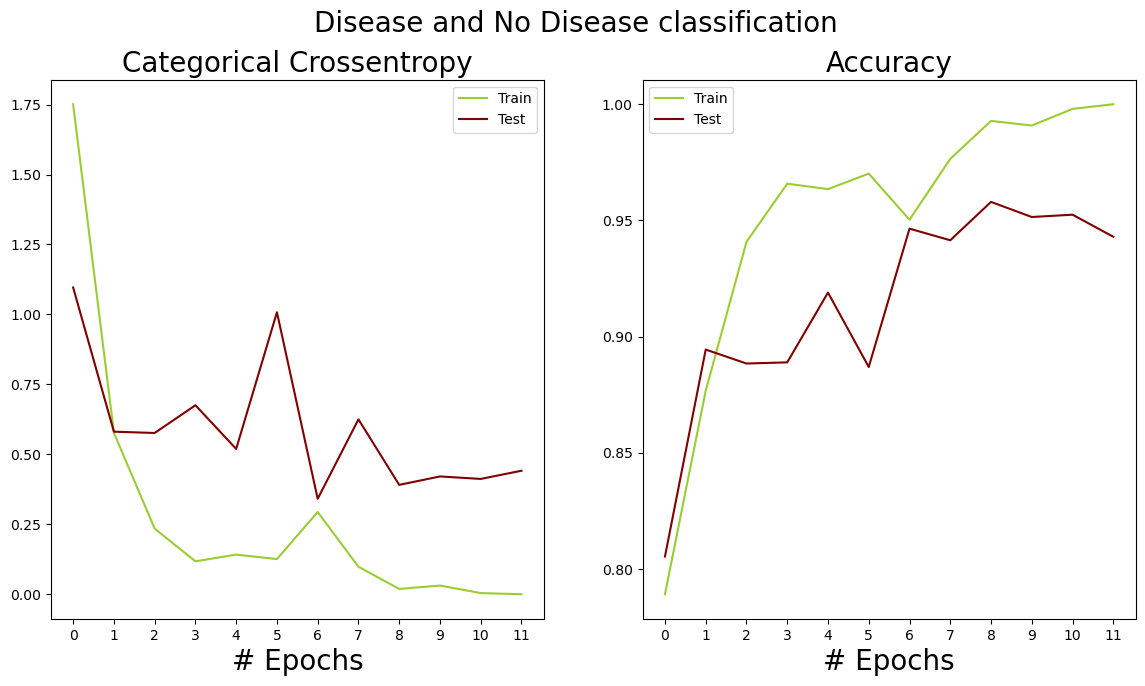

In [49]:
# Plot Crossentropy and Accuracy by epoch
functions.evaluation_plots(h, 'Disease and No Disease classification')

Accuracy_score: 0.9464 



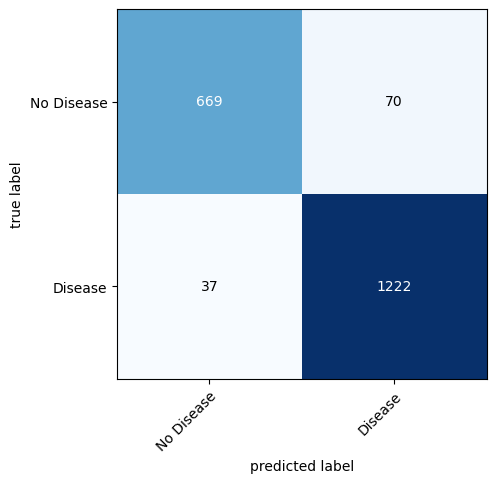

In [50]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model, X=X_val, y=y_val, class_names_list =  ['No Disease', 'Disease'], binary = True)

Accuracy_score: 0.7902 



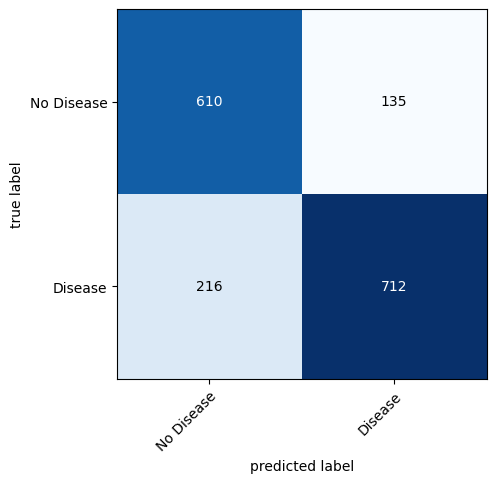

In [51]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model, X=X_test, y=y_test, class_names_list =  ['No Disease', 'Disease'], binary = True)

In [52]:
model.save('../models/disease_no_disease.hdf5')

## Make Binary data Alzheimer's - Brain tumor
Combine datasets, ignoring No disease images and make binary data - Alzheimer's  - 0, Brain tumor - 1

In [53]:
X_train_al_bt, X_val_al_bt, y_train_al_bt, y_val_al_bt = combine_images_from_two_path_binary(al_path_train, bt_path_train, function = al_bt_load_img_from_dir_binary)
X_train_al_bt.shape, y_train_al_bt.shape

((3777, 240, 240, 3), (3777,))

In [54]:
X_test_al_bt, y_test_al_bt = combine_images_from_two_path_binary(al_path_test, bt_path_test, function = al_bt_load_img_from_dir_binary)

In [55]:
effnet_bi = EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_shape=(image_size, image_size, 3),
    classifier_activation="sigmoid",
    include_preprocessing=True,
)


# Freeze last 5 layers
for layer in effnet_bi.layers[:-5]:
    layer.trainable = False

In [56]:
model_al_bt = Sequential()

model_al_bt.add(effnet_bi)
model_al_bt.add(GlobalAveragePooling2D())


#Just use a single output layer
model_al_bt.add(Dense(1, activation='sigmoid'))

# Compile
model_al_bt.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

h_al_bt = model_al_bt.fit(X_train_al_bt, y_train_al_bt, validation_data = (X_val_al_bt, y_val_al_bt), epochs=30, callbacks = [es, reduce_lr])

Epoch 1/30
119/119 [==============================] - 217s 2s/step - loss: 0.0153 - accuracy: 0.9934 - val_loss: 2.4671e-04 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 2/30
119/119 [==============================] - 216s 2s/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 6.9703e-05 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/30
119/119 [==============================] - 225s 2s/step - loss: 5.0141e-04 - accuracy: 1.0000 - val_loss: 3.9283e-05 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/30
119/119 [==============================] - 220s 2s/step - loss: 4.4461e-04 - accuracy: 0.9997 - val_loss: 8.2211e-05 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 5/30
119/119 [==============================] - 224s 2s/step - loss: 7.8390e-04 - accuracy: 0.9997 - val_loss: 5.6258e-05 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 6/30
119/119 [==============================] - 229s 2s/step - loss: 1.6142e-04 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 0.9992 - lr: 0.0010
Epoch 7/30
119/119 [========

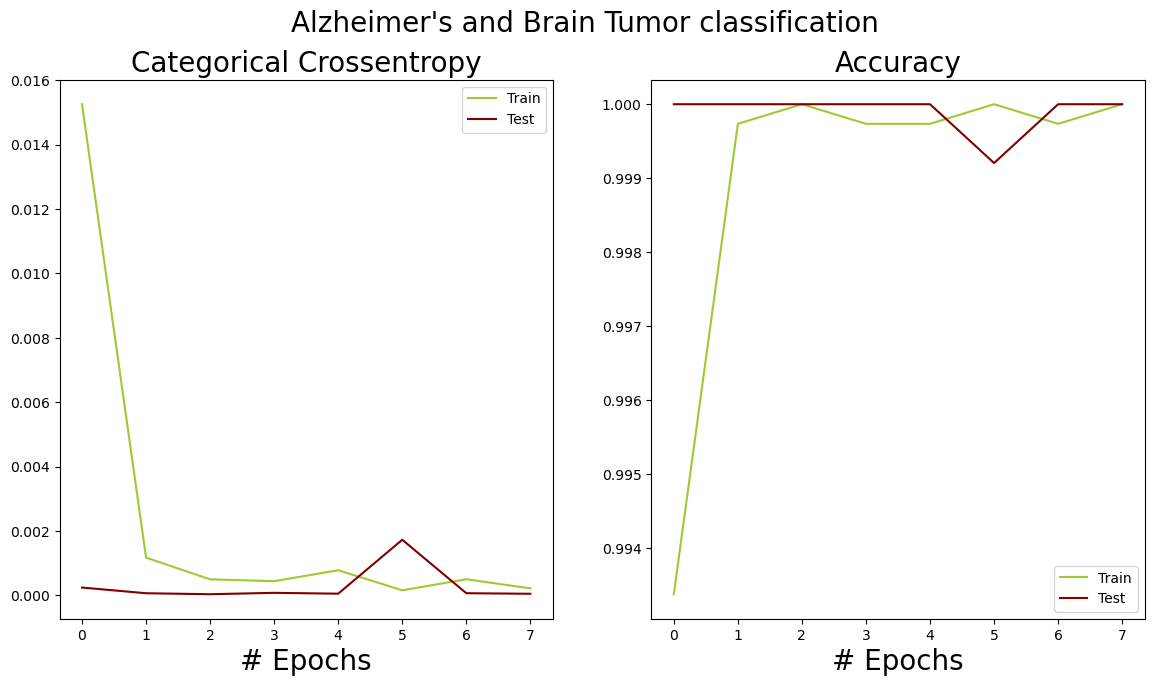

In [57]:
# Plot Crossentropy and Accuracy by epoch
functions.evaluation_plots(h_al_bt, 'Alzheimer\'s and Brain Tumor classification')

Accuracy_score: 1.0 



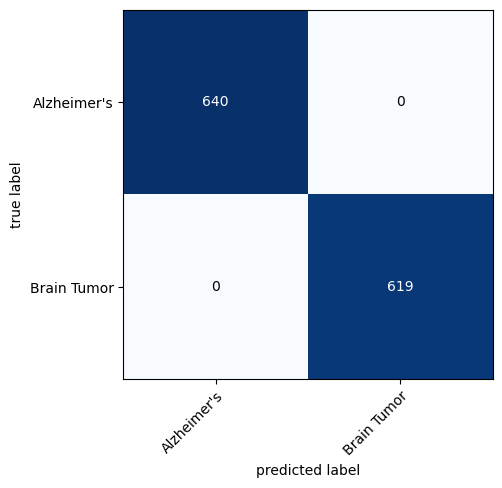

In [58]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model_al_bt, X=X_val_al_bt, y=y_val_al_bt, class_names_list =  ['Alzheimer\'s', 'Brain Tumor'], binary = True)

Accuracy_score: 1.0 



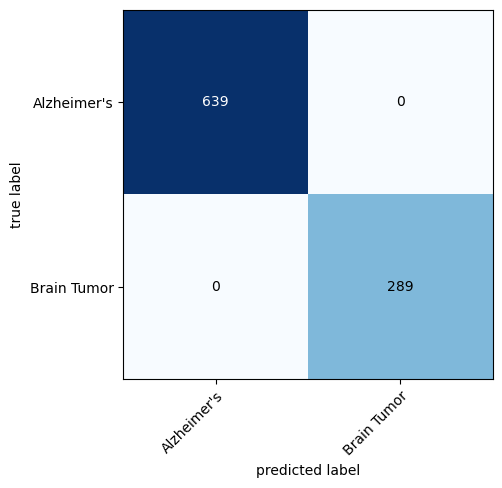

In [59]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model_al_bt, X=X_test_al_bt, y=y_test_al_bt, class_names_list =  ['Alzheimer\'s', 'Brain Tumor'], binary = True)

In [60]:
model_al_bt.save('../models/al_bt.hdf5')

In [56]:
model_al_bt = Sequential()

model_al_bt.add(effnet_bi)
model_al_bt.add(GlobalAveragePooling2D())


#Just use a single output layer
model_al_bt.add(Dense(1, activation='sigmoid'))

# Compile
model_al_bt.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

h_al_bt = model_al_bt.fit(X_train_al_bt, y_train_al_bt, validation_data = (X_val_al_bt, y_val_al_bt), epochs=30, callbacks = [es, reduce_lr])

Epoch 1/30
119/119 [==============================] - 243s 2s/step - loss: 0.1225 - accuracy: 0.9550 - val_loss: 0.0294 - val_accuracy: 0.9889 - lr: 0.0010
Epoch 2/30
119/119 [==============================] - 251s 2s/step - loss: 0.0528 - accuracy: 0.9780 - val_loss: 0.0142 - val_accuracy: 0.9952 - lr: 0.0010
Epoch 3/30
119/119 [==============================] - 234s 2s/step - loss: 0.0370 - accuracy: 0.9860 - val_loss: 0.0130 - val_accuracy: 0.9952 - lr: 0.0010
Epoch 4/30
119/119 [==============================] - 225s 2s/step - loss: 0.0346 - accuracy: 0.9860 - val_loss: 0.0073 - val_accuracy: 0.9968 - lr: 0.0010
Epoch 5/30
119/119 [==============================] - 231s 2s/step - loss: 0.0349 - accuracy: 0.9846 - val_loss: 0.0096 - val_accuracy: 0.9968 - lr: 0.0010
Epoch 6/30
119/119 [==============================] - 225s 2s/step - loss: 0.0331 - accuracy: 0.9860 - val_loss: 0.0086 - val_accuracy: 0.9968 - lr: 0.0010
Epoch 7/30
119/119 [==============================] - 223s 2s/st

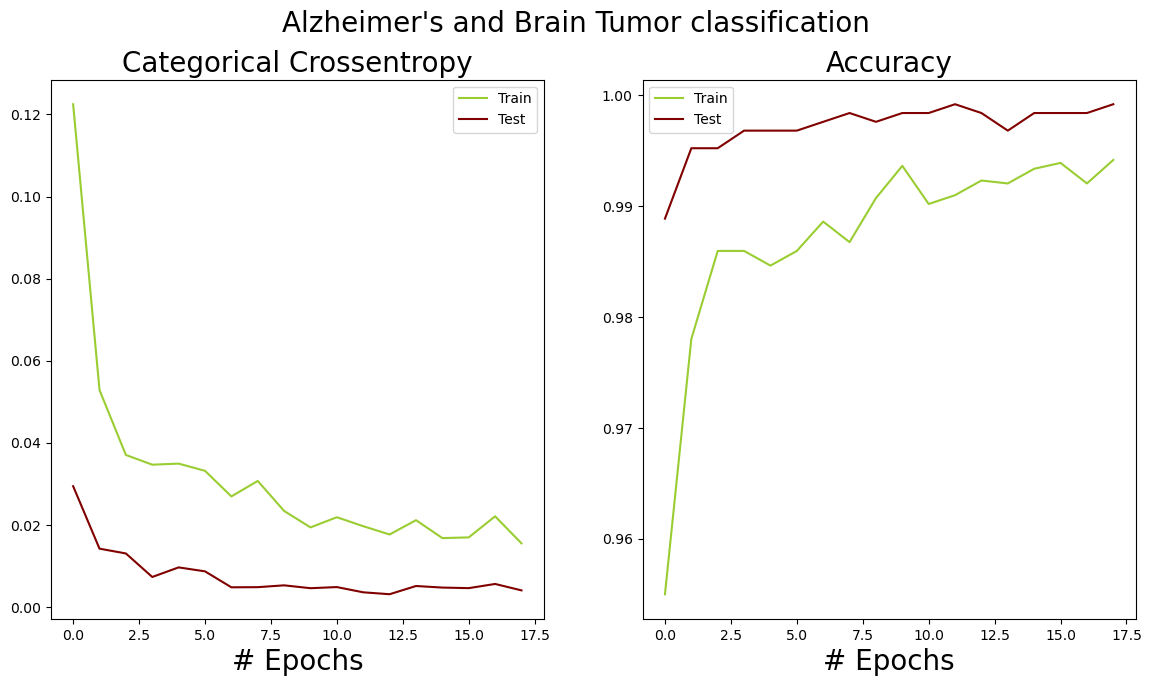

In [57]:
# Plot Crossentropy and Accuracy by epoch
functions.evaluation_plots(h_al_bt, 'Alzheimer\'s and Brain Tumor classification')

Accuracy_score: 0.9984 



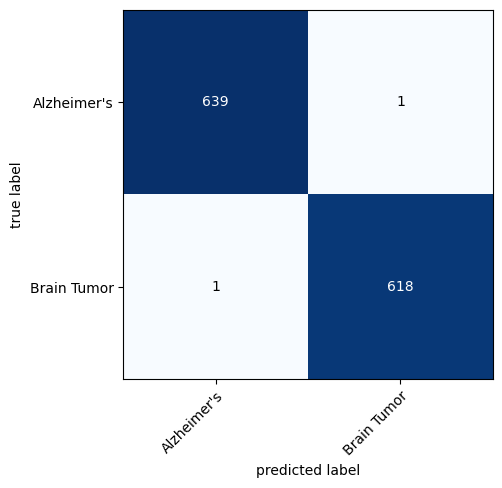

In [58]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model_al_bt, X=X_val_al_bt, y=y_val_al_bt, class_names_list =  ['Alzheimer\'s', 'Brain Tumor'], binary = True)

Accuracy_score: 0.9989 



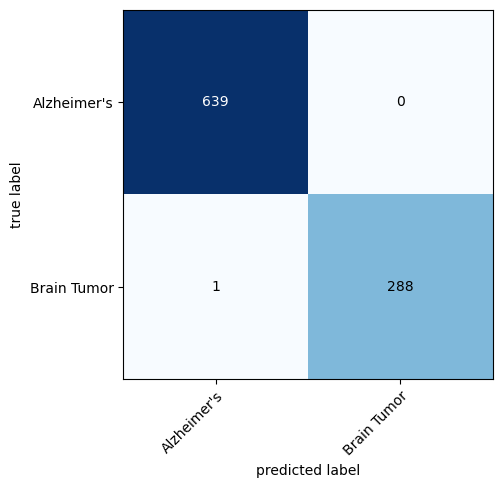

In [59]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model_al_bt, X=X_test_al_bt, y=y_test_al_bt, class_names_list =  ['Alzheimer\'s', 'Brain Tumor'], binary = True)

In [72]:
model_al_bt.save('../models/al_bt.hdf5')

## Predict Sevetiry of Alzeimer's or Type of Brain Tumor

### Sevetiry of Alzeimer's

In [61]:
X_train_al, X_val_al, y_train_al, y_val_al = load_img_from_dir_cat(al_path_train)
X_train_al.shape, y_train_al.shape

((1920, 240, 240, 3), (1920, 3))

In [62]:
X_test_al, y_test_al = load_img_from_dir_cat(al_path_test)

In [63]:
rn_model = resnet50.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(image_size, image_size, 3),
    classes=3,
    classifier_activation="softmax"
)

In [64]:
for layer in rn_model.layers:
    layer.trainable = False

In [65]:
model_al = Sequential()

model_al.add(rn_model)
model_al.add(Flatten())

#Just use a single output layer
model_al.add(Dense(3, activation='softmax'))

# Compile
model_al.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

h_al = model_al.fit(X_train_al, y_train_al, validation_data = (X_val_al, y_val_al), epochs=30, callbacks = [es, reduce_lr])

Epoch 1/30
60/60 [==============================] - 97s 2s/step - loss: 5.5810 - accuracy: 0.6969 - val_loss: 0.7421 - val_accuracy: 0.8846 - lr: 0.0010
Epoch 2/30
60/60 [==============================] - 95s 2s/step - loss: 0.2064 - accuracy: 0.9453 - val_loss: 0.4199 - val_accuracy: 0.9002 - lr: 0.0010
Epoch 3/30
60/60 [==============================] - 96s 2s/step - loss: 0.2485 - accuracy: 0.9354 - val_loss: 0.5069 - val_accuracy: 0.9080 - lr: 0.0010
Epoch 4/30
60/60 [==============================] - 94s 2s/step - loss: 0.1424 - accuracy: 0.9719 - val_loss: 0.4738 - val_accuracy: 0.8830 - lr: 0.0010
Epoch 5/30
60/60 [==============================] - 95s 2s/step - loss: 0.1091 - accuracy: 0.9698 - val_loss: 0.5678 - val_accuracy: 0.9111 - lr: 0.0010
Epoch 6/30
60/60 [==============================] - 94s 2s/step - loss: 0.2856 - accuracy: 0.9401 - val_loss: 0.3927 - val_accuracy: 0.9220 - lr: 0.0010
Epoch 7/30
60/60 [==============================] - 97s 2s/step - loss: 0.0449 - a

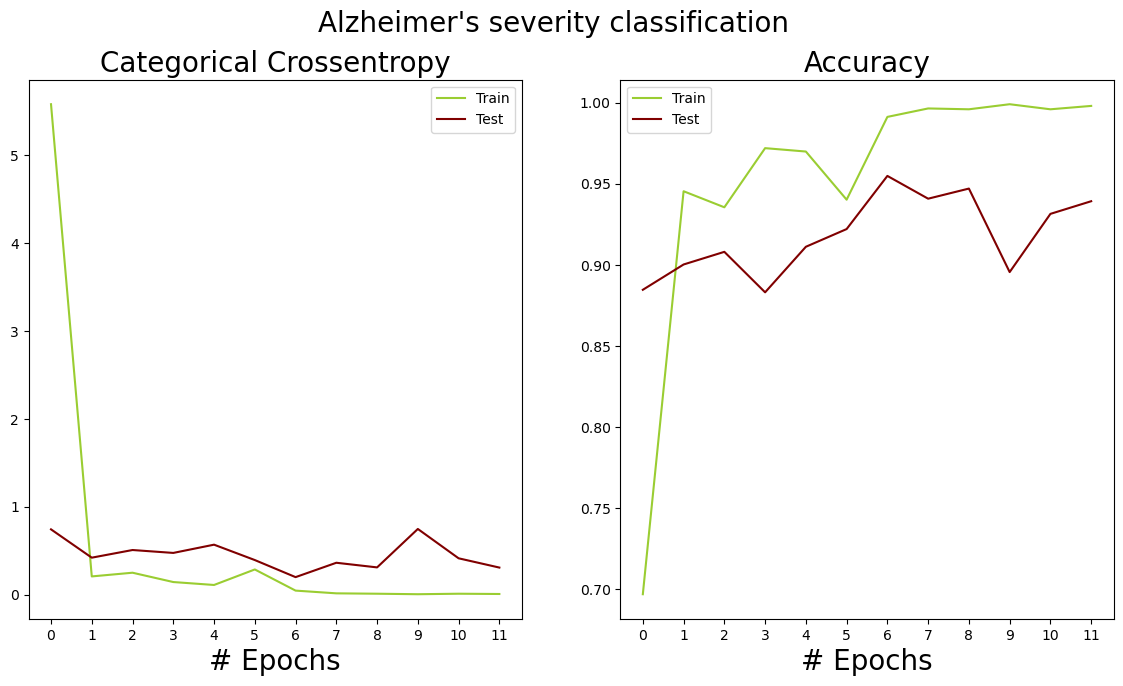

In [66]:
# Plot Crossentropy and Accuracy by epoch
functions.evaluation_plots(h_al, 'Alzheimer\'s severity classification')

Accuracy_score: 0.9548 



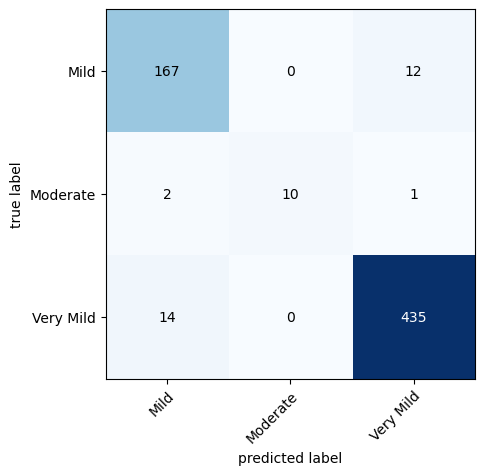

In [67]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model_al, X=X_val_al, y=y_val_al, class_names_list = ['Mild', 'Moderate', 'Very Mild'])

Accuracy_score: 0.7731 



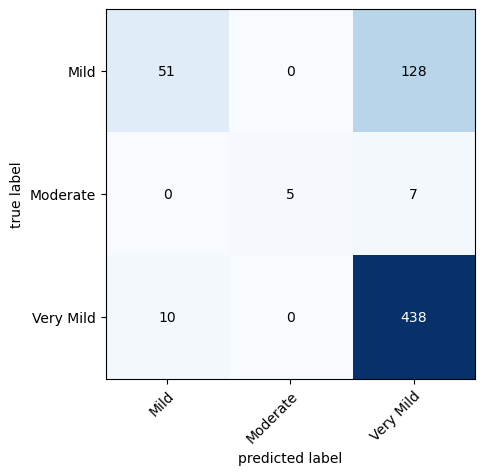

In [68]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model_al, X=X_test_al, y=y_test_al, class_names_list = ['Mild', 'Moderate', 'Very Mild'])

In [69]:
model_al.save('../models/model_al.hdf5')

### Type of Brain Tumor

In [70]:
X_train_bt, X_val_bt, y_train_bt, y_val_bt = load_img_from_dir_cat(bt_path_train)
X_train_bt.shape, y_train_bt.shape

((1856, 240, 240, 3), (1856, 3))

In [71]:
X_test_bt, y_test_bt = load_img_from_dir_cat(bt_path_test)

In [72]:
effnet = EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_shape=(image_size, image_size, 3),
    classes=3,
    classifier_activation="softmax",
    include_preprocessing=True,
)
# Freeze last 5 layers
for layer in effnet.layers[:-5]:
    layer.trainable = False

In [73]:
model_bt = Sequential()

model_bt.add(effnet)
model_bt.add(GlobalAveragePooling2D())
model_bt.add(Dropout(.2))

#Just use a single output layer
model_bt.add(Dense(3, activation='softmax'))

# Compile
model_bt.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

h_bt = model_bt.fit(X_train_bt, y_train_bt, validation_data = (X_val_bt, y_val_bt), epochs=30, callbacks=[es, reduce_lr])

Epoch 1/30
58/58 [==============================] - 119s 2s/step - loss: 0.5363 - accuracy: 0.7796 - val_loss: 0.3729 - val_accuracy: 0.8498 - lr: 0.0010
Epoch 2/30
58/58 [==============================] - 112s 2s/step - loss: 0.3549 - accuracy: 0.8578 - val_loss: 0.3309 - val_accuracy: 0.8643 - lr: 0.0010
Epoch 3/30
58/58 [==============================] - 110s 2s/step - loss: 0.2980 - accuracy: 0.8885 - val_loss: 0.2769 - val_accuracy: 0.8853 - lr: 0.0010
Epoch 4/30
58/58 [==============================] - 122s 2s/step - loss: 0.2509 - accuracy: 0.9106 - val_loss: 0.2489 - val_accuracy: 0.9095 - lr: 0.0010
Epoch 5/30
58/58 [==============================] - 108s 2s/step - loss: 0.2064 - accuracy: 0.9283 - val_loss: 0.2019 - val_accuracy: 0.9257 - lr: 0.0010
Epoch 6/30
58/58 [==============================] - 104s 2s/step - loss: 0.1841 - accuracy: 0.9359 - val_loss: 0.1981 - val_accuracy: 0.9338 - lr: 0.0010
Epoch 7/30
58/58 [==============================] - 171s 3s/step - loss: 0.1

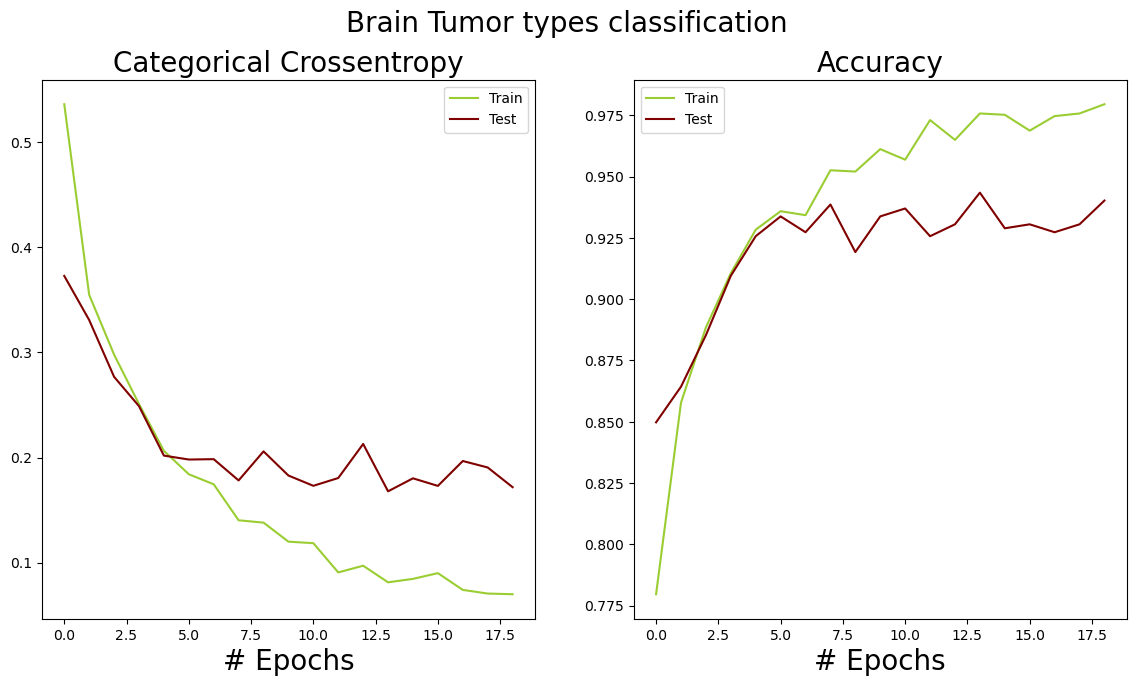

In [74]:
# Plot Crossentropy and Accuracy by epoch
functions.evaluation_plots(h_bt, 'Brain Tumor types classification')

Accuracy_score: 0.9435 



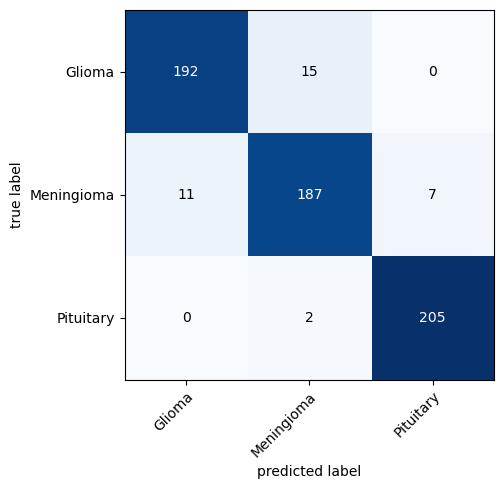

In [75]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model_bt, X=X_val_bt, y=y_val_bt, class_names_list = ['Glioma', 'Meningioma', 'Pituitary'])

Accuracy_score: 0.7093 



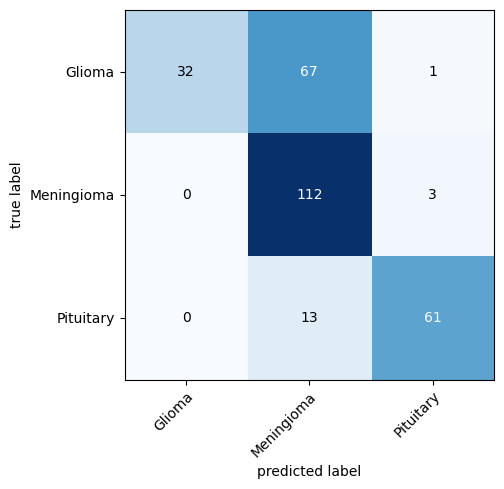

In [76]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model_bt, X=X_test_bt, y=y_test_bt, class_names_list = ['Glioma', 'Meningioma', 'Pituitary'])

In [78]:
model_bt.save('../models/model_bt.hdf5')

In [ ]:
 img = load_img(f'{path}/{label}/{image_file}', target_size=(image_size, image_size), color_mode='grayscale')
                    img = expand_dims(img, -1)
                    # Make image RGB for pre-trained models
                    img = grayscale_to_rgb(img)
                    img_arr = img_to_array(img) 

## Combine all to classify a single input image

In [86]:
def preprosses_image(image_path):
    '''
    '''
    test_img = load_img(image_path, target_size=(image_size, image_size), color_mode='grayscale')
    test_img = expand_dims(test_img, -1)
    test_img = grayscale_to_rgb(test_img)
    test_img = img_to_array(test_img)
    test_img = expand_dims(test_img, 0)
    return test_img

In [9]:
def predict_image(image_path):
    '''
    '''
    test_img = preprosses_image(image_path)
    predicted_dis_no_dis = model.predict(test_img)
    predicted_dis_no_dis = np.argmax(predicted_dis_no_dis, axis = 1)[0]
    if predicted_dis_no_dis < 0.5:
        return 'No disease found in MRI'
    else:
        predict_al_bt = model_al_bt.predict(test_img)
        predict_al_bt = np.argmax(predict_al_bt, axis = 1)[0]
        if predict_al_bt < 0.5:
            predict_al = model_al.predict(test_img)
            predict_al = np.argmax(predict_al, axis = 1)[0]
            al_list = ['Mild', 'Moderate', 'Very Mild']
            return al_list[predict_al]
        else:
            predict_bt = model_bt.predict(test_img)
            predict_bt = np.argmax(predict_bt, axis = 1)[0]
            bt_list = ['Glioma', 'Meningioma', 'Pituitary']
            return bt_list[predict_bt]

In [14]:
# Load models
disease_no_disease = load_model('disease_no_disease.hdf5')
model_al = load_model('model_al.hdf5')
model_al_bt = load_model('al_bt.hdf5')
model_bt = load_model('model_bt.hdf5')

In [89]:
image_do_d = preprosses_image('../data/alzheimer/train/NonDemented/nonDem8.jpg')

In [90]:
image_al_vm = preprosses_image('../data/alzheimer/train/VeryMildDemented/verymildDem0.jpg')

In [91]:
image_al_mo = preprosses_image('../data/alzheimer/train/ModerateDemented/moderateDem25.jpg')

In [92]:
image_al_ml = preprosses_image('../data/alzheimer/train/MildDemented/mildDem37.jpg')

In [93]:
image_bt_g = preprosses_image('../data/brain_tumor/train/glioma_tumor/gg (40).jpg')

In [94]:
image_bt_m = preprosses_image('../data/brain_tumor/train/meningioma_tumor/m (14).jpg')

In [95]:
image_bt_p = preprosses_image('../data/brain_tumor/train/pituitary_tumor/p (794).jpg')

In [88]:
image_bt_p.shape

TensorShape([1, 240, 240, 3])

In [111]:
predictions = (model_al_bt.predict(image_al_ml, verbose = False) > 0.5).astype("int32")

In [112]:
predictions[0][0]

0

In [98]:
pred_d = (model_al_bt.predict(image_al_vm, verbose = False) > 0.5).astype("int32")

In [99]:
pred_d[0]

array([0])

In [100]:
pred_d = (model_al_bt.predict(image_bt_m, verbose = False) > 0.5).astype("int32")

In [101]:
pred_d[0]

array([1])

In [102]:
pred_d = (model_al_bt.predict(image_bt_g, verbose = False) > 0.5).astype("int32")

In [103]:
pred_d[0]

array([1])

In [104]:
predictions = model_al.predict(image_al_vm, verbose = False).argmax(axis=1)
predictions[0]

2

In [105]:
predictions = model_al.predict(image_al_mo, verbose = False).argmax(axis=1)
predictions[0]

1

In [106]:
predictions = model_al.predict(image_al_ml, verbose = False).argmax(axis=1)
predictions[0]

0

In [107]:
predictions = model_bt.predict(image_bt_g, verbose = False).argmax(axis=1)
predictions[0]

0

In [108]:
predictions = model_bt.predict(image_bt_m, verbose = False).argmax(axis=1)
predictions[0]

1

In [109]:
predictions = model_bt.predict(image_bt_p, verbose = False).argmax(axis=1)
predictions[0]

2

In [145]:
image = preprosses_image('../data/alzheimer/train/MildDemented/mildDem1.jpg')

In [150]:
image = preprosses_image('../data/brain_tumor/train/meningioma_tumor/m (14).jpg')

In [151]:
predicted_dis_no_dis = model_al_bt.predict(image)

16/16 [==============================] - 33s 2s/step


In [152]:
(predicted_dis_no_dis.mean()).astype("int32")

0

In [130]:
pred = predict_image('../data/alzheimer/train/MildDemented/mildDem1.jpg')

7/7 [==============================] - 14s 2s/step


In [116]:
np.argmax(pred, axis = 1)[0]

2

In [131]:
pred

'No disease found in MRI'

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, smart_resize
import numpy as np


image_path = '../data/brain_tumor/test/meningioma_tumor/image(2).jpg'

image_size = 240

test_img = img_to_array(load_img(image_path, color_mode = "grayscale"))
test_img = smart_resize(test_img, (image_size, image_size))
test_img = np.expand_dims(test_img, axis=0)

test_img.shape

In [ ]:
    test_img = Image.open(your_image)
    test_img = keras.preprocessing.image.img_to_array(test_img)
    test_img = expand_dims(test_img, -1)
    test_img = image.grayscale_to_rgb(test_img)
    test_img = keras.preprocessing.image.smart_resize(test_img, (240, 240))